Bachelor thesis Data Mining
Bielefeld University
Lukas Wüppelmann

## Data set
The file `partial_credit_data` contains Data of of students and tasks where every column represents a student and every row a task with possible point range [0,3]

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# our data set models a fictional class of students completing a
# number of tasks and is samples from a ground truth 2-PL IRT model
# BUT with a twist, namely that the ground truth ability is actually
# two-dimensional, not uni-dimensional. Still, the abilities are
# correlated, so that a uni-dimensional construct can cover the data
# quite well.

N = 150

# here is our Q matrix
Q = np.array([
   [2., 0.],
   [0., 2.],
   [1., 0.2],
   [0.2, 1.],
   [1., 0.5],
   [0.5, 1.],
   [1., 1.]
])

# here our difficulties for each achievable point value
B = np.array([
   [-1., 0., 2.],
   [-1., 0., 2.],
   [-1, 0.5, 1.5],
   [-1, 0.5, 1.5],
   [0.7, 1., 2.],
   [0.7, 1., 2.],
   [0.5, 1.5, 1.8]
])


A = 4

abilities = np.random.randn(N, 2)

# compute the logit success probabilities of every student on every task
Z = np.zeros((N, B.shape[0], B.shape[1] + 1))
for i in range(N):
   Z[i, :, 1:] = (np.expand_dims(np.dot(abilities[i, :], Q.T), 1) - B) * A

Z = np.cumsum(Z, axis = 2)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis = 2), 2)

# sample actual data
X = np.zeros((N, B.shape[0]))
for i in range(N):
   for j in range(B.shape[0]):
     X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)

np.savetxt('partial_credit_data.csv', X, fmt = '%g', delimiter = '\t',
encoding = 'utf-8')

In [48]:
import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('partial_credit_data.csv', delimiter = '\t', dtype=int)
N, m = X.shape
print(X)

print("number of students: " + str(N))
print("number of tasks: " + str(m))

[[2 1 2 ... 2 0 0]
 [3 1 2 ... 2 0 1]
 [3 3 2 ... 3 2 3]
 ...
 [0 0 0 ... 0 0 0]
 [3 2 2 ... 3 2 3]
 [0 2 0 ... 0 0 0]]
number of students: 150
number of tasks: 7


## Pytorch setup

In [2]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [82]:
import torch

class IRTModel(torch.nn.Module):
    """The initialization method of a pytorch module. Here, we should set all hyperparameters
    of the model, such as the regularization strength.

    Parameters
    ----------
    C: float (default = 1000)
        The inverse of the L2 regularization strength.
    num_epochs: int (default = 1000)
        How many times we iterate over the data set during training.
    learning_rate: float (default = 1E-2)
        The learning rate of our optimizer during training.
    """
    def __init__(self, C = 1000, num_epochs = 1000, learning_rate = 1E-2):
        # We call the torch.nn.Module constructor
        super(IRTModel, self).__init__()
        # Then, we store all hyperparameters as attributes of the model
        self.C_ = C
        self.num_epochs_ = num_epochs
        self.learning_rate_ = learning_rate

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Z: torch.tensor
        A matrix where each row represents a student and each column represents a task.
        The entry Z[i, j] represents the logit probability of student i passing task j.
    
    """
    def predict_logits(self, X = None):
        # the logits correspond to the difference of abilities and difficulties.
        # The 'unsqueeze' method transforms the abilities vector from an N-entry
        # vector to an (N, 1)-matrix and the difficulties vector from an m-entry
        # vector to an (1, m)-matrix, such that the difference - thanks to the
        # magic of broadcasting - yields a (N, m) matrix.
        Z = self.abilities_.unsqueeze(1) - self.difficulties_.unsqueeze(0)
        return Z

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Xhat: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry Xhat[i, j] is 1 if the model predicts student i to pass task j and 0
        otherwise.
    
    """
    def predict(self, X = None):
        Z = self.predict_logits()
        Xhat = torch.zeros_like(Z)
        Xhat[Z > 0.] = 1.
        return Xhat.detach().numpy()

    """Fits this model to the given data matrix.

    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    """
    def fit(self, X):
        # convert the input matrix to a pytorch tensor
        X = torch.tensor(X, dtype=torch.float)
        # initialize our model parameters based on passing rates, meaning:
        # students have higher initial ability if they get more tasks right and
        # items have higher initial difficulty if less students get them right.
        self.abilities_    = torch.nn.Parameter(torch.mean(X, 1).detach() - 0.5)
        self.difficulties_ = torch.nn.Parameter(0.5 - torch.mean(X, 0).detach())
        # initialize optimizer with the right learning rate and regularization strength
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate_, weight_decay=1./self.C_)
        # start training
        for epoch in range(self.num_epochs_):
            # re-set the current gradient to zero
            optimizer.zero_grad()
            # predict the logit passing probabilities for each student-item combination
            # with the current model
            Z = self.predict_logits()
            # compute the loss between predicted and desired answers using the crossentropy loss
            loss = torch.nn.functional.binary_cross_entropy_with_logits(Z, X)
            # report the loss every 100 steps
            if (epoch+1) % 100 == 0:
                print('epoch %d: loss %g' % (epoch+1, loss.item()))
            # compute the gradient
            loss.backward()
            # apply the optimizer
            optimizer.step()
        
        return self

## training

In [83]:
model_pytorch = IRTModel()
model_pytorch.fit(X)
Xhat = model_pytorch.predict(X)
accuracy = np.mean(Xhat == X)
print(f'Accuracy: {accuracy:.2f}')
print(Xhat)


epoch 100: loss -0.901313
epoch 200: loss -1.39042
epoch 300: loss -1.79679
epoch 400: loss -2.14637
epoch 500: loss -2.45288
epoch 600: loss -2.72582
epoch 700: loss -2.97245
epoch 800: loss -3.19838
epoch 900: loss -3.40794
epoch 1000: loss -3.60444
Accuracy: 0.43
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


## VAE

In [59]:
import torch
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories):
        super(VAE, self).__init__()
        self.num_categories = num_categories
        self.n_ = num_latent
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        self.dec2 = torch.nn.Linear(num_neurons, num_inputs)

    def forward(self, X):
        # Encoding
        H_enc = torch.nn.functional.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.n_]
        LogSigma = Mu_and_LogSigma[:, self.n_:]
        # Sampling
        Z = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)
        # Decoding
        H_dec = torch.nn.functional.relu(self.dec1(Z))
        Y = self.dec2(H_dec)
        # Scaling the output to 0-3 range
        Y = torch.sigmoid(Y) * (self.num_categories - 1)
        return Mu, LogSigma, Z, Y

    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 1000
        lambda_ = 0.1
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # Start training
        for epoch in range(num_epochs):
            # Reset the current gradient to zero
            optimizer.zero_grad()
            # Autoencode the data
            Mu, LogSigma, Z, Y = self.forward(X)
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(torch.square(Z))
            neg_log_qzx = torch.sum(LogSigma)
            neg_log_pxz = 0.5 / lambda_ ** 2 * torch.sum(torch.square(X - Y))
            loss = neg_log_pxz + neg_log_pz - neg_log_qzx
            # Compute the gradient via backpropagation
            loss.backward()
            # Apply the optimizer
            optimizer.step()

In [60]:
num_inputs = 7  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 4

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")


C:\Users\wuepp\AppData\Local\Temp\ipykernel_21304\437249586.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Accuracy: 0.9066666666666666


In [63]:
import torch
import torch.nn.functional as F
import numpy as np

class VAE_PC(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories, noise = 0.01, regul = 0.1, monotonic_penalty_parameter = 1, q_penalty_parameter = 1):
        super(VAE_PC, self).__init__()
        self.q_penalty_parameter = q_penalty_parameter
        self.monotonic_penalty_parameter = monotonic_penalty_parameter
        self.noise = noise
        self.regul = regul
        self.num_inputs = num_inputs
        self.num_latent = num_latent
        self.num_categories = num_categories
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        #self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        #self.dec2 = torch.nn.Linear(num_latent, num_inputs)
        # Definiere eine Matrix für Diskriminationsparameter (Q)
        self.Q = torch.nn.Parameter(torch.abs(torch.randn(num_latent, num_inputs)))

        # Diskriminationsparameter und Schwellenwerte initialisieren
        self.a = torch.nn.Parameter(torch.ones(num_inputs))  # Diskriminationsparameter
        #self.a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        self.b = torch.nn.Parameter(torch.randn(num_inputs, num_categories - 1))  # Schwellenwerte
        #self.b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing

    def forward(self, X):
        # Encoding
        H_enc = torch.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.num_latent]
        LogSigma = Mu_and_LogSigma[:, self.num_latent:]
        # Sampling
        # eventuell noise parameter 10e-2
        theta = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)*self.noise
        # Decoding
        #H_dec = torch.relu(self.dec1(Z))
        
        #raw_logits = self.dec2(theta)  # Fähigkeitsschätzung
        #nich constrainter layer bis jetzt
        #print(raw_logits)

        #Apply softplus to ensure Q is positive
        #learned_Q = torch.nn.functional.softplus(self.Q)
        
        #Apply ReLU
        #learned_Q = torch.relu(self.Q)

        # Matrix-basiertes Decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrixmultiplikation

        # Initialisiere eine leere Liste für die Logits (logarithmischen Wahrscheinlichkeiten)
        logits = []

        #a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        #b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing
        
        # Schleife über die Anzahl der Inputs (Items im Test)
        for i in range(self.num_inputs):
            # Initialisiere eine leere Liste für die Logits eines einzelnen Items
            item_logits = []
            
            # Schleife über die Kategorien des aktuellen Items
            for k in range(self.num_categories):
                if k == 0:
                    # Für die erste Kategorie (k = 0) setzen wir die Logits auf Null
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Berechne die Logits für die restlichen Kategorien
                    # Die Logits sind kumulativ, d.h., sie basieren auf den vorherigen Logits
                    item_logits.append((raw_logits[:, i] - self.b[i, k-1]) * self.a[i] + item_logits[-1])
            
            # Füge die Logits des aktuellen Items zur Liste hinzu, und stacke sie entlang der letzten Dimension
            logits.append(torch.stack(item_logits, dim=-1))

        # Stacke die Logits aller Items entlang der zweiten Dimension
        logits = torch.stack(logits, dim=1)
        # Wende die Softmax-Funktion auf die Logits an, um die Wahrscheinlichkeitsverteilung über die Kategorien zu erhalten
        Y = torch.softmax(logits, dim=-1)

        # Gib die anderen Variablen und die Wahrscheinlichkeiten zurück
        return Mu, LogSigma, theta, Y
    
    
        
        """
        logits = []

        for i in range(self.num_inputs):
            item_logits = []
            
            # Neue Berechnung: raw_logits_item repräsentiert den Einfluss der latenten Fähigkeiten
            raw_logits_item = torch.sum(theta * self.a[i], dim=1)
            
            for k in range(self.num_categories):
                if k == 0:
                    item_logits.append(torch.zeros_like(raw_logits_item))
                else:
                    # Berechne die Logits unter Berücksichtigung der Schwellenwerte b
                    item_logits.append((raw_logits_item - self.b[i, k-1]) + item_logits[-1])
            
            logits.append(torch.stack(item_logits, dim=-1))

        logits = torch.stack(logits, dim=1)
        Y = torch.softmax(logits, dim=-1)

        return Mu, LogSigma, theta, Y
        """



    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 5000
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_values = []
        
        # Start training
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            Mu, LogSigma, theta, Y = self.forward(X)
            
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(theta ** 2) * self.regul
            neg_log_qzx = torch.sum(LogSigma) * self.regul
            X_onehot = F.one_hot(X.long(), num_classes=self.num_categories).float()
            neg_log_pxz = -torch.sum(X_onehot * torch.log(Y + 1e-10))
            original_loss = neg_log_pxz + neg_log_pz - neg_log_qzx

            # Monotonicity penalty
            diffs = self.b[:, 1:] - self.b[:, :-1]
            mono_penalty = torch.sum(F.relu(-diffs))

            # Penalize negative values in Q

            q_penalty = torch.sum(F.relu(-self.Q))
            
            loss = original_loss + self.monotonic_penalty_parameter * mono_penalty + self.q_penalty_parameter * q_penalty
            loss_values.append(loss.item())
            
            loss.backward()
            optimizer.step()

            if (epoch % 100 == 0):
                print(f"Epoch {epoch}, Loss: {loss.item()}")

        # Plot the loss curve
        plt.plot(loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.show()

        # Extracting model parameters
        diffs = self.b[:, 1:] - self.b[:, :-1]
        b_values = self.b.detach().numpy()
        a_values = self.a.detach().numpy()

        # Comparing the discrimination parameters (a)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title('Discrimination Parameters (a)')
        plt.plot(a_values, label='Model Parameters')
        plt.plot([A] * len(a_values), label='True Parameters', linestyle='--')
        plt.legend()

        # Comparing the threshold parameters (b)
        plt.subplot(1, 2, 2)
        plt.title('Threshold Parameters (b)')
        plt.plot(b_values.flatten(), label='Model Parameters')
        plt.plot(B.flatten(), label='True Parameters', linestyle='--')
        plt.legend()

        plt.show()

        learned_Q = self.Q.detach().numpy()

        learned_Q_transposed = learned_Q.T


        # Compare the true Q matrix with the learned Q matrix
        true_Q = Q  # Use the Q matrix from your data generation

        print("b values:\n", b_values)
        print("original B values:\n", B)
        print("Differences (should be non-negative):\n", diffs.detach().numpy())
        print("a values (should be positive):\n", a_values)


        if learned_Q_transposed.size == true_Q.size:
            diff_Q = learned_Q_transposed - true_Q
            print("Learned Q matrix:\n", learned_Q_transposed)
            print("True Q matrix:\n", true_Q)
            print("Difference Q matrix:\n", diff_Q)


"""
def fit(self, X):
    # Initialize everything before training
    learning_rate = 1E-3
    num_epochs = 1000
    lambda_ = 0.1
    X = torch.tensor(X, dtype=torch.float)
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    # Start training
    for epoch in range(num_epochs):
        # Reset the current gradient to zero
        optimizer.zero_grad()
        # Autoencode the data
        Mu, LogSigma, Z, Y = self.forward(X)
        # Compute the loss function
        neg_log_pz = 0.5 * torch.sum(torch.square(Z))
        neg_log_qzx = torch.sum(LogSigma)
        neg_log_pxz = 0.5 / lambda_ ** 2 * torch.sum(torch.square(X - Y))
        loss = neg_log_pxz + neg_log_pz - neg_log_qzx
        # Compute the gradient via backpropagation
        loss.backward()
        # Apply the optimizer
        optimizer.step()
"""


'\ndef fit(self, X):\n    # Initialize everything before training\n    learning_rate = 1E-3\n    num_epochs = 1000\n    lambda_ = 0.1\n    X = torch.tensor(X, dtype=torch.float)\n    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)\n    # Start training\n    for epoch in range(num_epochs):\n        # Reset the current gradient to zero\n        optimizer.zero_grad()\n        # Autoencode the data\n        Mu, LogSigma, Z, Y = self.forward(X)\n        # Compute the loss function\n        neg_log_pz = 0.5 * torch.sum(torch.square(Z))\n        neg_log_qzx = torch.sum(LogSigma)\n        neg_log_pxz = 0.5 / lambda_ ** 2 * torch.sum(torch.square(X - Y))\n        loss = neg_log_pxz + neg_log_pz - neg_log_qzx\n        # Compute the gradient via backpropagation\n        loss.backward()\n        # Apply the optimizer\n        optimizer.step()\n'

C:\Users\wuepp\AppData\Local\Temp\ipykernel_21304\2317784687.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 1855.656494140625
Epoch 100, Loss: 1196.1900634765625
Epoch 200, Loss: 1011.216796875
Epoch 300, Loss: 902.7416381835938
Epoch 400, Loss: 812.8961181640625
Epoch 500, Loss: 753.2022705078125
Epoch 600, Loss: 709.3544921875
Epoch 700, Loss: 668.019287109375
Epoch 800, Loss: 636.4430541992188
Epoch 900, Loss: 605.8853759765625
Epoch 1000, Loss: 580.7181396484375
Epoch 1100, Loss: 555.7297973632812
Epoch 1200, Loss: 534.1321411132812
Epoch 1300, Loss: 510.9767761230469
Epoch 1400, Loss: 495.6090087890625
Epoch 1500, Loss: 473.4837951660156
Epoch 1600, Loss: 454.39459228515625
Epoch 1700, Loss: 439.5875244140625
Epoch 1800, Loss: 420.2991638183594
Epoch 1900, Loss: 404.22125244140625
Epoch 2000, Loss: 390.35992431640625
Epoch 2100, Loss: 374.7924499511719
Epoch 2200, Loss: 363.3683166503906
Epoch 2300, Loss: 352.1790771484375
Epoch 2400, Loss: 339.3616638183594
Epoch 2500, Loss: 329.19110107421875
Epoch 2600, Loss: 322.4818115234375
Epoch 2700, Loss: 315.74847412109375
Epoch

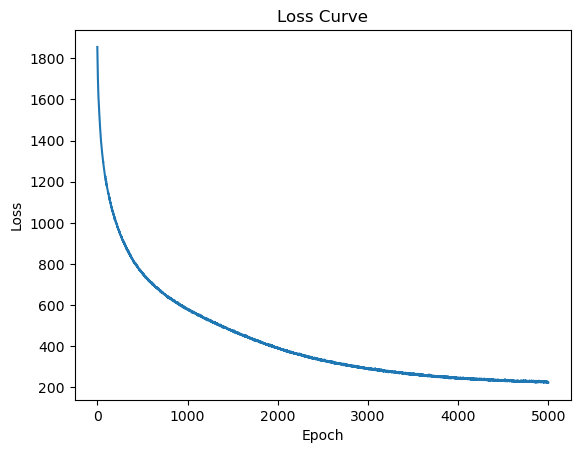

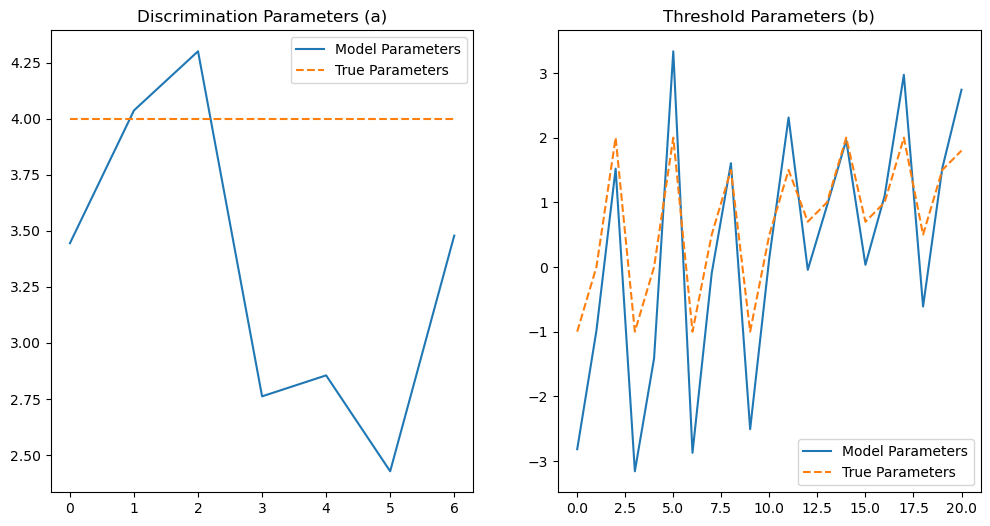

b values:
 [[-2.8184605  -0.98489535  1.5205153 ]
 [-3.159422   -1.4144881   3.3359995 ]
 [-2.8741207  -0.09593339  1.6047702 ]
 [-2.5080833   0.147355    2.312418  ]
 [-0.04395689  0.9482897   1.9608186 ]
 [ 0.03350138  1.1018158   2.9719214 ]
 [-0.61180896  1.5284401   2.7415056 ]]
original B values:
 [[-1.   0.   2. ]
 [-1.   0.   2. ]
 [-1.   0.5  1.5]
 [-1.   0.5  1.5]
 [ 0.7  1.   2. ]
 [ 0.7  1.   2. ]
 [ 0.5  1.5  1.8]]
Differences (should be non-negative):
 [[1.8335651  2.5054107 ]
 [1.7449338  4.7504873 ]
 [2.7781873  1.7007036 ]
 [2.6554384  2.165063  ]
 [0.99224657 1.0125289 ]
 [1.0683144  1.8701056 ]
 [2.140249   1.2130655 ]]
a values (should be positive):
 [3.445054  4.0378327 4.30169   2.7615519 2.8552186 2.4271674 3.4789197]
Learned Q matrix:
 [[ 2.4688556  -0.0822145 ]
 [-0.09782777  3.8943274 ]
 [ 1.737636    0.21544896]
 [ 0.23261489  1.8201356 ]
 [ 1.4446812   0.5871017 ]
 [ 0.7509247   1.829271  ]
 [ 1.7572374   1.545612  ]]
True Q matrix:
 [[2.  0. ]
 [0.  2. ]
 [

In [58]:
num_inputs = 7  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=4)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

#print(Xhat)

### Usability Datensatz

In [61]:
import numpy as np

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('main_sheet_sus.csv', skip_header=1, delimiter=',')

X = data[:, 3:].astype(int)
# Shape der Daten erhalten
N, m = X.shape

# Daten ausgeben
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))


[[1 4 5 4 4 1 2 1 5 1 5 1 5 1 4 1 4 1 5 1]
 [2 1 5 1 4 2 5 1 4 1 4 1 4 1 4 2 5 2 5 1]
 [1 2 3 4 4 4 2 2 1 5 4 1 4 2 4 2 5 2 4 3]
 [4 5 5 4 5 4 4 1 4 5 5 1 5 1 5 1 5 1 5 4]
 [4 1 4 1 4 1 5 1 4 1 4 1 5 1 4 1 4 1 4 1]
 [4 1 5 1 4 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1]
 [4 1 5 1 5 2 5 1 5 2 4 2 4 2 2 3 5 5 5 1]
 [5 1 5 5 5 1 5 1 5 3 3 1 5 4 5 1 5 1 4 3]
 [4 2 4 4 5 2 5 1 4 1 4 4 4 5 5 1 4 2 5 4]
 [4 1 2 2 5 2 5 1 4 2 5 1 5 1 5 1 4 1 4 5]
 [1 1 5 1 3 1 1 1 5 1 2 1 5 1 5 1 1 1 5 5]
 [3 1 5 1 5 1 3 1 5 1 3 1 5 1 5 1 5 1 5 1]
 [1 2 5 1 4 1 4 1 5 4 5 2 4 1 5 1 5 1 5 1]
 [1 1 5 1 3 1 4 2 4 2 5 1 5 1 4 1 4 1 5 1]
 [5 1 4 1 5 1 4 1 4 1 5 1 4 1 4 1 4 1 5 2]
 [1 1 5 1 4 2 4 1 4 2 3 1 5 1 5 1 5 1 5 1]
 [1 2 4 2 4 2 3 2 4 1 4 1 4 1 5 2 3 1 5 1]
 [2 1 5 1 5 1 5 2 5 2 4 1 5 1 5 1 5 1 5 1]
 [1 2 4 1 4 5 4 2 4 2 4 2 5 1 4 5 3 2 3 1]
 [1 1 4 2 4 3 4 2 4 2 1 2 5 1 5 1 4 1 4 2]
 [1 1 2 1 2 4 4 1 4 4 5 2 5 1 4 2 4 1 4 5]
 [2 2 4 2 5 2 4 1 4 2 4 3 4 1 5 3 5 1 5 1]
 [1 1 5 1 5 2 4 2 4 1 2 1 4 1 5 1 4 2 4 2]
 [1 1 4 1 4

C:\Users\wuepp\AppData\Local\Temp\ipykernel_21304\2067561475.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 1626.1712646484375
Epoch 100, Loss: 997.790283203125
Epoch 200, Loss: 885.0291748046875
Epoch 300, Loss: 812.068359375
Epoch 400, Loss: 766.1127319335938
Epoch 500, Loss: 735.68408203125
Epoch 600, Loss: 712.5506591796875
Epoch 700, Loss: 692.2511596679688
Epoch 800, Loss: 675.0531616210938
Epoch 900, Loss: 659.8350219726562
Epoch 1000, Loss: 645.9374389648438
Epoch 1100, Loss: 637.0838623046875
Epoch 1200, Loss: 621.2506103515625
Epoch 1300, Loss: 611.9609985351562
Epoch 1400, Loss: 600.170654296875
Epoch 1500, Loss: 591.6426391601562
Epoch 1600, Loss: 583.5706787109375
Epoch 1700, Loss: 574.7138671875
Epoch 1800, Loss: 565.6187744140625
Epoch 1900, Loss: 558.275146484375
Epoch 2000, Loss: 552.7852172851562
Epoch 2100, Loss: 544.5349731445312
Epoch 2200, Loss: 538.678955078125
Epoch 2300, Loss: 532.4905395507812
Epoch 2400, Loss: 526.634765625
Epoch 2500, Loss: 521.88623046875
Epoch 2600, Loss: 517.9293823242188
Epoch 2700, Loss: 513.993896484375
Epoch 2800, Loss: 509.8

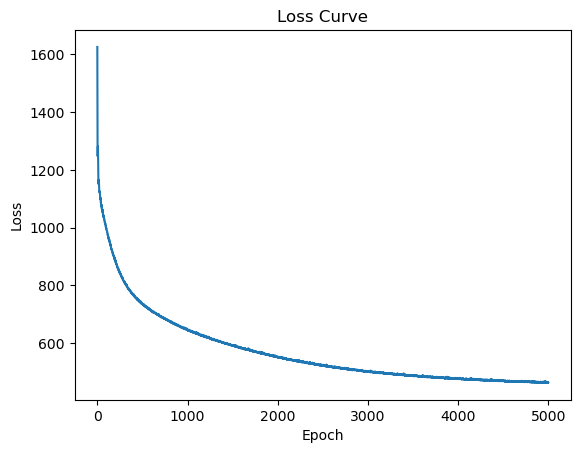

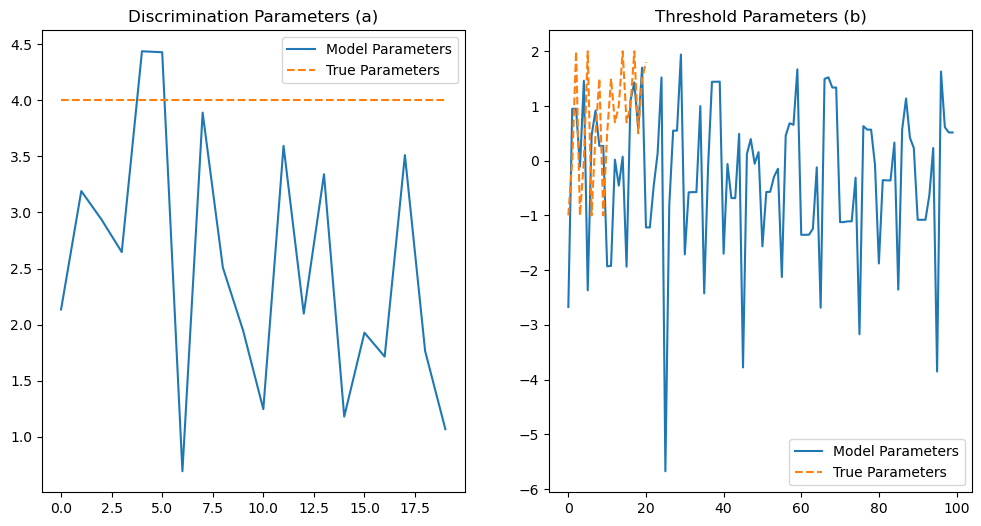

b values:
 [[-2.6742122   0.9488536   0.9486861  -0.1080151   1.4610608 ]
 [-2.3693852   0.46421614  0.91561884  0.26916495  0.26952028]
 [-1.9302453  -1.9238094   0.01825681 -0.45578256  0.07239909]
 [-1.9375262   1.0980864   1.4295775   0.58268344  1.7018182 ]
 [-1.2199651  -1.2198148  -0.45603094  0.13422883  1.5216525 ]
 [-5.6770573  -0.81987065  0.54961944  0.5496249   1.9395075 ]
 [-1.7132891  -0.57835925 -0.57403475 -0.5740524   0.99844366]
 [-2.4253416  -0.10865975  1.4423589   1.443437    1.4448305 ]
 [-1.7004572  -0.06082341 -0.68420815 -0.68449944  0.4901641 ]
 [-3.7788923   0.12398029  0.3953043  -0.05553458  0.15678099]
 [-1.5666349  -0.57119274 -0.5693108  -0.2903688  -0.14724515]
 [-2.1264226   0.45943567  0.6836855   0.6557007   1.6702646 ]
 [-1.3550116  -1.3544567  -1.3524058  -1.2442487  -0.12184692]
 [-2.687441    1.4942759   1.5243862   1.3378012   1.3378375 ]
 [-1.1228538  -1.1219581  -1.1085498  -1.1086555  -0.31049013]
 [-3.1722076   0.632451    0.56804174  0.567

In [64]:
num_inputs = 20  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=6)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

#print(Xhat)

In [10]:
num_inputs = 20  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 6

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")


NameError: name 'VAE' is not defined